[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

<a name="0"></a> 
# Image Segmentation for Nuclei Data 

* [Kaggle Data Science Bowl 2018](https://www.kaggle.com/c/data-science-bowl-2018) 

---

## Notebook Contents 

* [1. Load and Preprocess Data](#1) 
* [2. Define U-Net Architecture](#2) 
* [3. Fitting Model](#3) 
* [4. Model Evaluation](#4)
* [5. Get Predictions and Plot](#5) 
* [6. Summary](#6) 
___


In [1]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# set directory 
import os 
os.chdir('/content/drive/My Drive/thesis/image_segmentation') 
print('Working Directory:', os.getcwd()) 

# load packages 
import numpy as np 
import pandas as pd 
import keras.backend as K 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split 

import tensorflow as tf 
from keras import Model 
from keras.layers import Input, Conv2D, MaxPool2D, Dropout 
from keras.layers import Conv2DTranspose, UpSampling2D, concatenate 
from keras.optimizers import Adam 
from keras.callbacks import ModelCheckpoint, EarlyStopping 
K.set_floatx('float32') 

Working Directory: /content/drive/My Drive/thesis/image_segmentation


<a name="1"></a> 
# 1. Load and Preprocess Data 

[Notebook Contents](#0) | [Summary](#6) 

---

* 670 total observations 
* 90% for train data: 603 observations 
* 10% for validation data: 67 observations 


In [3]:
def load_train_data(path): 
    data = np.load(path) 
    return data['images'], data['masks'] 

# load data 
path = 'nuclei_data/train_data.npz' 
X, y = load_train_data(path) 

# split into training, testing, validation data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=7) 
print('Training Data Dimensions:') 
print('X_train = ', X_train.shape) 
print('y_train = ', y_train.shape) 
print('\nTesting Data Dimensions:') 
print('X_test = ', X_test.shape) 
print('y_test = ', y_test.shape) 

Training Data Dimensions:
X_train =  (603, 128, 128, 3)
y_train =  (603, 128, 128, 1)

Testing Data Dimensions:
X_test =  (67, 128, 128, 3)
y_test =  (67, 128, 128, 1)


<a name="2"></a> 
# 2. Define U-Net Architecture

[Notebook Contents](#0) | [Summary](#6) 

In [4]:
def dice_coef(y_true, y_pred, axis=(1, 2, 3), e=1e-5): 
    y_true = tf.cast(y_true, dtype=tf.float32) 
    y_pred = tf.cast(y_pred, dtype=tf.float32) 
    numerator = 2*K.sum(y_true*y_pred, axis=axis) + e 
    denominator = K.sum(y_true, axis=axis) + K.sum(y_pred, axis=axis) + e 
    return K.mean(numerator/denominator) 

def soft_dice(y_true, y_pred, axis=(1, 2, 3), e=1e-5): 
    y_true = tf.cast(y_true, dtype=tf.float32) 
    y_pred = tf.cast(y_pred, dtype=tf.float32) 
    numerator = 2*K.sum(y_true*y_pred, axis=axis) + e 
    denominator = K.sum(y_true**2, axis=axis) + K.sum(y_pred**2, axis=axis) + e 
    loss = 1 - K.mean(numerator/denominator) 
    return loss 

def conv_block(x_in, n_filt, kernel, activation, kernel_init, drop_size=0.2): 
    x = Conv2D(n_filt, kernel, padding='same', activation=activation, 
               kernel_initializer=kernel_init)(x_in) 
    x = Dropout(drop_size)(x) 
    x = Conv2D(n_filt, kernel, padding='same', activation=activation, 
               kernel_initializer=kernel_init)(x) 
    return x 

def pool(x_in, pool_size): 
    return MaxPool2D(pool_size=pool_size, padding='same')(x_in) 

def tr_conv(x_in, n_filt, kernel=(2,2), strides=(2,2)): 
    return Conv2DTranspose(n_filt, kernel, strides, padding='same')(x_in) 

def up_samp(x_in, size=(2,2)): 
    return UpSampling2D(size=size)(x_in) 

def encoder_block(x_in, n_filt, kernel, activation, kernel_init, pool_size=(2,2)): 
    c = conv_block(x_in, n_filt, kernel, activation, kernel_init) 
    p = pool(c, pool_size) 
    return c, p 

def decoder_trconv_block(x_in, x_skip, n_filt, kernel, activation, kernel_init, size=(2,2)):
    up = tr_conv(x_in, n_filt) 
    m = concatenate([up, x_skip]) 
    c = conv_block(m, n_filt, kernel, activation, kernel_init) 
    return c 

def decoder_upsamp_block(x_in, x_skip, n_filt, kernel, activation, kernel_init, size=(2,2)): 
    up = up_samp(x_in) 
    m = concatenate([up, x_skip]) 
    c = conv_block(m, n_filt, kernel, activation, kernel_init) 
    return c 

In [5]:
def uNet(input_shape, loss, metrics, depth=4, base_filt_pow=6, lr=1e-3, name=None, 
         activation='relu', kernel=(3,3), kernel_init='he_normal', tr_conv=True): 
    inputs = Input(shape=input_shape) 
    # encoder 
    filts = [] 
    encoder_conv_layers, encoder_pool_layers = [], [] 
    for i in range(depth): 
        if len(encoder_conv_layers) == 0: 
            x_in = inputs 
        else: 
            x_in = encoder_pool_layers[-1] 
        filts.append(2**(base_filt_pow+i)) 
        c, p = encoder_block(x_in, filts[i], kernel, activation, kernel_init) 
        encoder_conv_layers.append(c) 
        encoder_pool_layers.append(p) 
    # bottleneck 
    n_filt = 2 ** (base_filt_pow+depth)
    mid = conv_block(encoder_pool_layers[-1], n_filt, kernel, activation, kernel_init) 
    # decoder 
    filts = np.flip(filts) 
    skips = np.flip(encoder_conv_layers) 
    decoder_layers = [] 
    for i in range(depth): 
        if len(decoder_layers) == 0: 
            x_in = mid 
        else: 
            x_in = decoder_layers[-1] 
        if tr_conv: 
            x = decoder_trconv_block(x_in, skips[i], filts[i], kernel, activation, kernel_init) 
        else: 
            x = decoder_upsamp_block(x_in, skips[i], filts[i], kernel, activation, kernel_init) 
        decoder_layers.append(x) 
    outputs = Conv2D(1, (1,1), activation='sigmoid')(decoder_layers[-1]) 
    # define model 
    model = Model(inputs=[inputs], outputs=[outputs], name=name) 
    model.compile(optimizer=Adam(learning_rate=lr), loss=loss, metrics=metrics) 
    return model 

# define model 
model = uNet(input_shape=X_train.shape[1:], 
             loss=soft_dice, metrics=[dice_coef], 
             name='UNet_Nuclei_Segmentation_Model') 
model.summary() 

Model: "UNet_Nuclei_Segmentation_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       dropout[0][0]                    
_____________________________________________________________________

The U-Net model has 31,031,745 total trainable parameters that will be learnt when the model is fit. 

---

<a name="3"></a> 
# 3. Fitting Model 

[Notebook Contents](#0) | [Summary](#6) 

---

* The model is fit for 500 epochs using a batch size of 16
* 10% of training observations are set aside for validation during training 
* Early stopping with a patience of 15 and the best weights will be restored once training stops 

In [6]:
def fit_model(model, path, X, y, batch_size=16, epochs=500, patience=15): 
    if not os.path.exists('models/'): 
        os.makedirs('models/') 
    save = 'models/{}'.format(path) 
    cb = [ModelCheckpoint(save, monitor='val_loss', mode='min', verbose=1, save_best_only=True), 
          EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)] 
    hist = model.fit(X, y, batch_size, epochs, callbacks=cb, validation_split=0.1, shuffle=True) 
    return hist 

# fit model 
print('\nFitting model...') 
path='unet_fitted_model.h5' 
history = fit_model(model, path, X_train, y_train) 


Fitting model...
Epoch 1/500
34/34 [==============================] - ETA: 0s - loss: 0.4397 - dice_coef: 0.4614WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0041s vs `on_test_batch_end` time: 0.0510s). Check your callbacks.

Epoch 00001: val_loss improved from inf to 0.19204, saving model to models/unet_fitted_model.h5
34/34 [==============================] - 13s 387ms/step - loss: 0.4397 - dice_coef: 0.4614 - val_loss: 0.1920 - val_dice_coef: 0.7628
Epoch 2/500
34/34 [==============================] - ETA: 0s - loss: 0.1964 - dice_coef: 0.7692
Epoch 00002: val_loss improved from 0.19204 to 0.18289, saving model to models/unet_fitted_model.h5
34/34 [==============================] - 8s 244ms/step - loss: 0.1964 - dice_coef: 0.7692 - val_loss: 0.1829 - val_dice_coef: 0.7903
Epoch 3/500
34/34 [==============================] - ETA: 0s - loss: 0.1918 - dice_coef: 0.7698
Epoch 00003: val_loss improved from 0.18289 to 0.16525, sa

The model trained for a total of 98 rounds before early stopping ceased training. 

---

<a name="4"></a> 
# 4. Model Evaluation 

[Notebook Contents](#0) | [Summary](#6) 

---

## Test Data Evaluation

Model evaluation for unseen observations. 

Test Data Evaluation:
 
Soft DICE Loss: 0.05358509719371796
DICE Coefficient: 0.9085283279418945
 
Plotting Training Soft DICE Loss and DICE Coefficient:


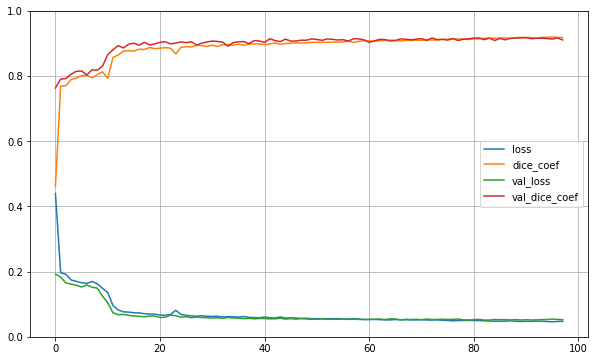

In [7]:
def evaluate_model(model, X, y, history=None): 
    scores = model.evaluate(X, y, verbose=0) 
    print(' ') 
    print('Soft DICE Loss:', scores[0]) 
    print('DICE Coefficient:', scores[1]) 
    print(' ') 
    if history is not None: 
        print('Plotting Training Soft DICE Loss and DICE Coefficient:') 
        pd.DataFrame(history.history).plot(figsize=(10, 6)) 
        plt.grid(True) 
        plt.gca().set_ylim(0, 1) 
        plt.show() 

# model evaluation for test data 
print('Test Data Evaluation:') 
evaluate_model(model, X_test, y_test, history) 

<a name="5"></a> 
# 5. Get Predictions and Plot 

[Notebook Contents](#0) | [Summary](#6) 

---

## Section Outline 

* [Plot Train Predictions](#5-1) 
* [Plot Test Predictions](#5-2) 
* [Plot Validation Predictions](#5-3) 

---

## Get Predictions 

In [8]:
# get predictions 
preds_train = model.predict(X_train, verbose=0) 
preds_test = model.predict(X_test, verbose=0) 

# create binary mask 
preds_train_masks = (preds_train > 0.5).astype(np.uint8) 
preds_test_masks = (preds_test > 0.5).astype(np.uint8) 

# functions to visualize predictions 
def plot_img(X, cmap=None):  
    plt.imshow(X, cmap=cmap) 
    plt.axis('off') 

def plot_predictions(X, y, preds, cmap=None): 
    # get random observation number 
    idx = np.random.randint(len(X)) 
    # plot training image, mask, and prediction 
    plt.figure(figsize=(10, 6)) 
    plt.subplot(1, 3, 1) 
    plot_img(X[idx], cmap=cmap) 
    plt.title('Image', size=16) 
    plt.subplot(1, 3, 2) 
    plot_img(np.squeeze(y[idx]), cmap=cmap) 
    plt.title('Mask', size=16) 
    plt.subplot(1, 3, 3) 
    plot_img(np.squeeze(preds[idx]), cmap=cmap) 
    plt.title('Predicted Mask', size=16) 
    plt.suptitle('Observation Number: {}'.format(idx), size=18) 
    plt.tight_layout() 

<a name="5-1"></a> 

## Plot Train Predictions

* [Section](#5) 

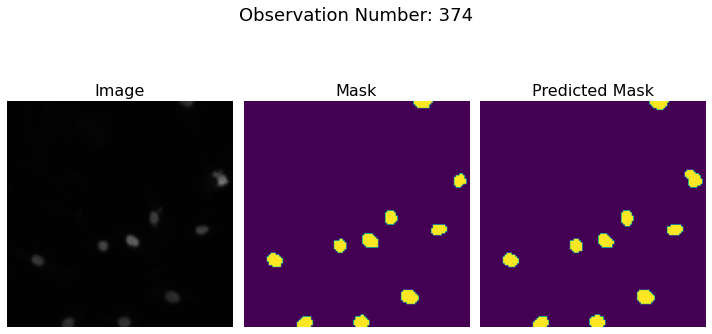

In [9]:
# plot train predictions 
plot_predictions(X_train, y_train, preds_train_masks) 

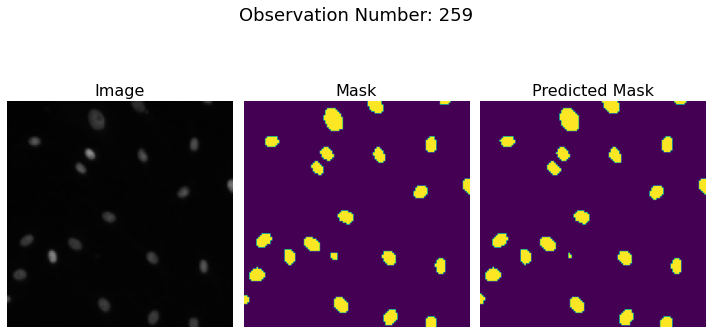

In [10]:
# plot train predictions 
plot_predictions(X_train, y_train, preds_train_masks) 

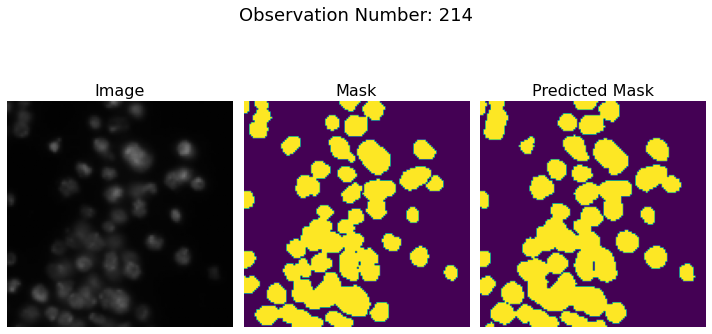

In [11]:
# plot train predictions 
plot_predictions(X_train, y_train, preds_train_masks) 

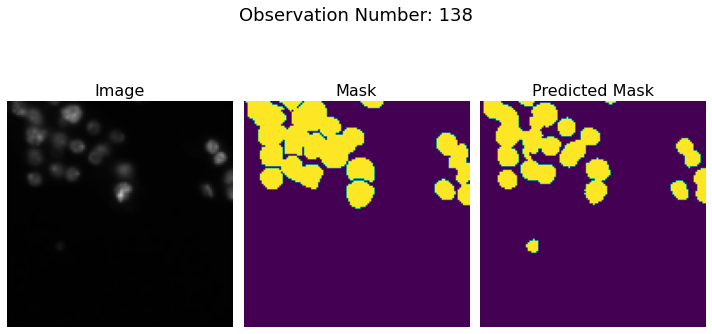

In [12]:
# plot train predictions 
plot_predictions(X_train, y_train, preds_train_masks) 

<a name="5-2"></a> 

## Plot Test Predictions

* [Section](#5) 

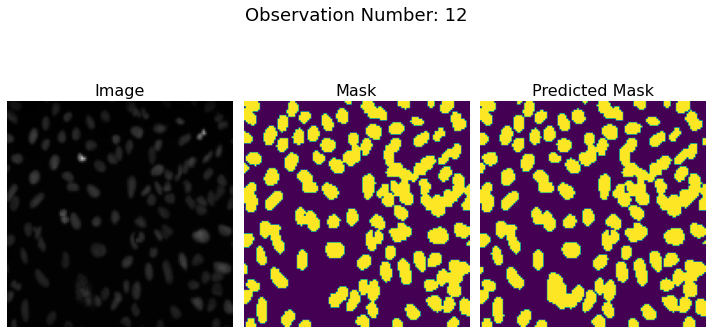

In [13]:
# plot test predictions 
plot_predictions(X_test, y_test, preds_test_masks) 

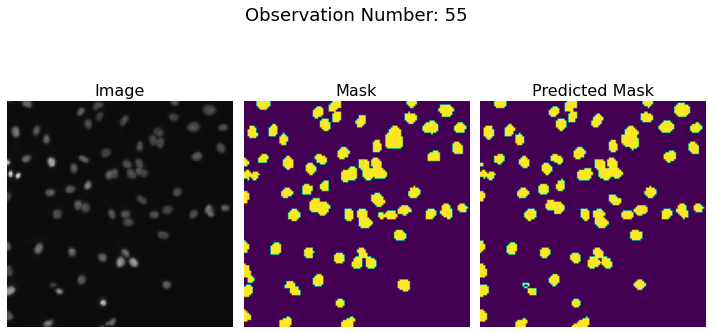

In [14]:
# plot test predictions 
plot_predictions(X_test, y_test, preds_test_masks) 

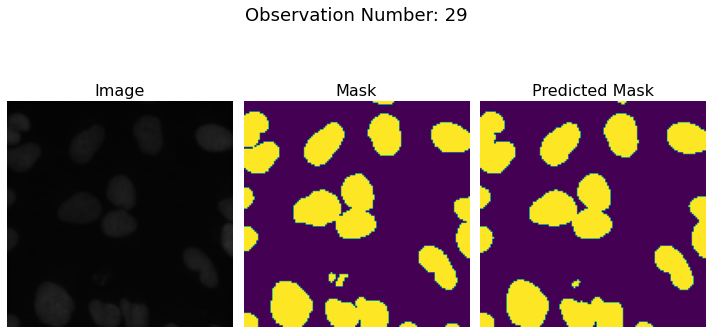

In [15]:
# plot test predictions 
plot_predictions(X_test, y_test, preds_test_masks) 

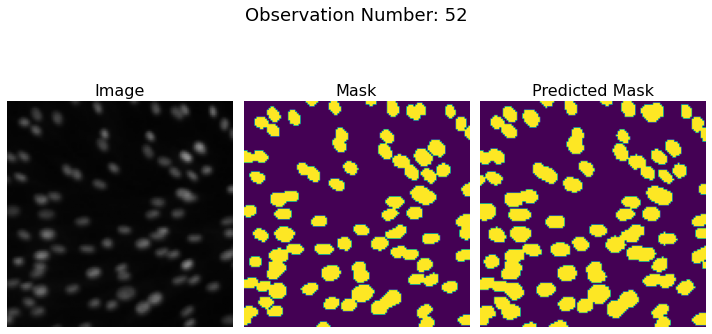

In [16]:
# plot test predictions 
plot_predictions(X_test, y_test, preds_test_masks) 

<a name="6"></a> 

# 6. Summary 

[Notebook Contents](#0) | [Model Evaluation](#4) | [Get Predictions and Plot](#5)

---

### Model Evaluation 

* Test Data 
  * Soft DICE Loss: 0.0536 
  * DICE Coefficient: 0.9085


